# Determine initial locations to start particle tracks

In [1]:
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np

from salishsea_tools import (
    nc_tools,
    viz_tools,
)
import datetime
from mpl_toolkits.basemap import Basemap, cm
import cmocean
import datetime

%matplotlib inline

/ocean/brogalla/GEOTRACES/analysis-birgit/cmocean-master/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [4]:
folder = '/data/brogalla/ANHA12/2015/'
gridT = 'ANHA12-EXH006_y2016m12d16_gridT.nc'

In [5]:
d1 = nc.Dataset(folder+gridT)

In [6]:
d1

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: GDT 1.3
    file_name: ANHA12-EXH006_y2016m12d16_gridT.nc
    production: OPA9.0 beta
    TimeStamp: 2017-MAR-26 14:04:31 GMT-0600
    dimensions(sizes): x(1632), y(2400), deptht(50), time_counter(1)
    variables(dimensions): float32 nav_lon(y,x), float32 nav_lat(y,x), float32 deptht(deptht), float32 time_counter(time_counter), float32 votemper(time_counter,deptht,y,x), float32 vosaline(time_counter,deptht,y,x), float32 sossheig(time_counter,y,x), float32 somxl010(time_counter,y,x), float32 sohmld(time_counter,y,x), float32 TRC01(time_counter,deptht,y,x), float32 TRC02(time_counter,deptht,y,x), float32 TRC03(time_counter,deptht,y,x), float32 TRC04(time_counter,deptht,y,x), float32 TRC05(time_counter,deptht,y,x), float32 sowaflup(time_counter,y,x), float32 amflxemp(time_counter,y,x), float32 amflxemps(time_counter,y,x), float32 amflxqla(time_counter,y,x), float32 MLD_500m(time_counter

In [7]:
def find_closest_model_point(
    lon, lat, model_lons, model_lats, grid='NEMO', land_mask=None,
    tols={
        'NEMO': {'tol_lon': 0.104, 'tol_lat': 0.0388},
        'GEM2.5': {'tol_lon': 0.016, 'tol_lat': 0.012},
        }
):
    """Returns the grid coordinates of the closest model point
    to a specified lon/lat. If land_mask is provided, returns the closest
    water point.

    Example:

    .. code-block:: python

        j, i = find_closest_model_point(
                   -125.5,49.2,model_lons,model_lats,land_mask=bathy.mask)

    where bathy, model_lons and model_lats are returned from
    :py:func:`salishsea_tools.tidetools.get_bathy_data`.

    j is the y-index(latitude), i is the x-index(longitude)

    :arg float lon: longitude to find closest grid point to

    :arg float lat: latitude to find closest grid point to

    :arg model_lons: specified model longitude grid
    :type model_lons: :py:obj:`numpy.ndarray`

    :arg model_lats: specified model latitude grid
    :type model_lats: :py:obj:`numpy.ndarray`

    :arg grid: specify which default lon/lat tolerances
    :type grid: string

    :arg land_mask: describes which grid coordinates are land
    :type land_mask: numpy array

    :arg tols: stored default tols for different grid types
    :type tols: dict

    :returns: yind, xind
    """

    if grid not in tols:
        raise KeyError(
            'The provided grid type is not in tols. '
            'Use another grid type or add your grid type to tols.')

    # Search for a grid point with longitude and latitude within
    # tolerance of measured location
    j_list, i_list = np.where(
        np.logical_and(
            (np.logical_and(model_lons > lon - tols[grid]['tol_lon'],
                            model_lons < lon + tols[grid]['tol_lon'])),
            (np.logical_and(model_lats > lat - tols[grid]['tol_lat'],
                            model_lats < lat + tols[grid]['tol_lat']))
        )
    )

    if len(j_list) == 0:
        # Added by BMM March 2017
        # If including points outside of domain:
        return np.nan, np.nan
        # raise ValueError(
        #    'No model point found. tol_lon/tol_lat too small or '
        #    'lon/lat outside of domain.')
    try:
        j, i = map(np.asscalar, (j_list, i_list))
    except ValueError:
        # Several points within tolerance
        # Calculate distances for all and choose the closest

        # Avoiding array indexing because some functions
        # pass in model_lons and model_lats as netcdf4 objects
        # (which treat 'model_lons[j_list, i_list]' differently)
        lons = [model_lons[j_list[n], i_list[n]] for n in range(len(j_list))]
        lats = [model_lats[j_list[n], i_list[n]] for n in range(len(j_list))]
        dists = haversine(
            np.array([lon] * i_list.size), np.array([lat] * j_list.size),
            lons, lats)
        n = dists.argmin()
        j, i = map(np.asscalar, (j_list[n], i_list[n]))

    # If point is on land and land mask is provided
    # try to find closest water point
    if land_mask is None or not land_mask[j, i]:
        return j, i
    try:
        return _spiral_search_for_closest_water_point(
            j, i, land_mask, lon, lat, model_lons, model_lats)
    except ValueError:
        raise ValueError(
            'lat/lon on land and no nearby water point found')


In [8]:
def haversine(lon1, lat1, lon2, lat2):
    """Calculate the great-circle distance in kilometers between two points
    on a sphere from their longitudes and latitudes.

    Reference: http://www.movable-type.co.uk/scripts/latlong.html

    :arg lon1: Longitude of point 1.
    :type lon1: float or :py:class:`numpy.ndarray`

    :arg lat1: Latitude of point 1.
    :type lat1: float or :py:class:`numpy.ndarray`

    :arg lon2: Longitude of point 2.
    :type lon2: float or :py:class:`numpy.ndarray`

    :arg lat2: Latitude of point 2.
    :type lat2: float or :py:class:`numpy.ndarray`

    :returns: Great-circle distance between two points in km
    :rtype: float or :py:class:`numpy.ndarray`
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [9]:
lons = d1.variables['nav_lon']
lats = d1.variables['nav_lat']
deptht = d1.variables['deptht']
temp = d1.variables['votemper']

In [10]:
lons = np.array(lons)
lats = np.array(lats)
deptht = np.array(deptht)
temp = np.array(temp)

Search for gridpoint location associated with these coordinates:

In [11]:
Barrow_strait = [74.051337, -83.872663] 

In [28]:
transect_lon = [-83.87,-83.87,-83.87,-83.87,-83.87,\
                -83.87,-83.87,-83.87,-83.87]
transect_lat = [73.70,73.80,73.90,74.00,74.10, \
                74.20,74.30,74.40,74.50]

In [29]:
BS1i, BS1j = find_closest_model_point(Barrow_strait[1], Barrow_strait[0], lons, lats)

In [30]:
transect_i = np.array([])
transect_j = np.array([])
for k in range(0,len(transect_lon)):
    i, j = find_closest_model_point(transect_lon[k], transect_lat[k], lons, lats)
    transect_i = np.append(transect_i, i)
    transect_j = np.append(transect_j, j)

In [31]:
print(BS1i, BS1j)

1596 501


In [34]:
part_lons = lons[BS1i, BS1j]
part_lats = lats[BS1i, BS1j]

In [35]:
transect_lons = [lons[transect_i[n],transect_j[n]] for n in range(0,len(transect_i))]
transect_lats = [lats[transect_i[n],transect_j[n]] for n in range(0,len(transect_i))]

/home/brogalla/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
/home/brogalla/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


Text(0.5,1,'Locations to release particles')

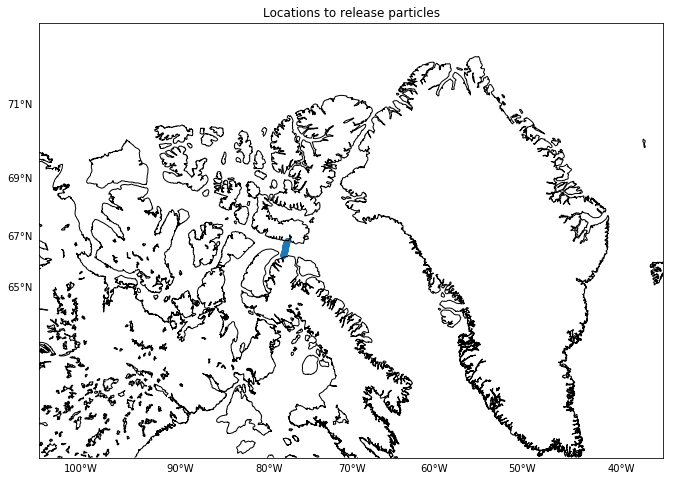

In [36]:
fig = plt.figure(figsize=(14,8))
ax1 = plt.subplot2grid((1, 1), (0, 0))

proj1=Basemap(projection='eqdc',lat_0 = 75, lon_0 = -70, resolution='i', width=3.95e6, height=2.75e6, ax=ax1)
proj1.drawparallels(np.arange(int(65),int(90),2),labels=[1,0,0,0], linewidth=0.0)
proj1.drawmeridians(np.arange(int(-140),int(-30),10),labels=[0,0,0,1], linewidth=0.0)
proj1.drawcoastlines()

x1, y1 = proj1(lons, lats)
part_i, part_j = proj1(transect_lons, transect_lats)
proj1.scatter(part_i, part_j)

ax1.set_title('Locations to release particles')

/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/home/brogalla/anaconda3/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


Text(0.5,1,'Locations to release particles, zoom')

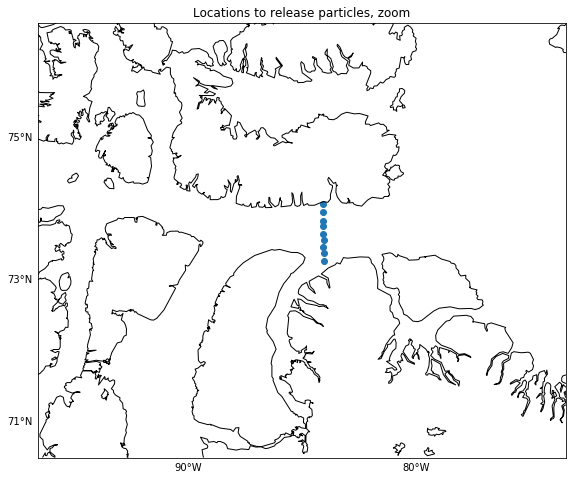

In [42]:
fig = plt.figure(figsize=(14,8))
ax1 = plt.subplot2grid((1, 1), (0, 0))

proj1=Basemap(projection='eqdc',lat_0 = 74, lon_0 = -85, resolution='i', width=0.85e6, height=0.70e6, ax=ax1)
proj1.drawparallels(np.arange(int(65),int(90),2),labels=[1,0,0,0], linewidth=0.0)
proj1.drawmeridians(np.arange(int(-140),int(-30),10),labels=[0,0,0,1], linewidth=0.0)
proj1.drawcoastlines()

x1, y1 = proj1(lons, lats)
part_i, part_j = proj1(transect_lons, transect_lats)
proj1.scatter(part_i, part_j)

ax1.set_title('Locations to release particles, zoom')

In [38]:
mask = nc.Dataset('/ocean/brogalla/GEOTRACES/Ariane/ANHA12_Ariane_mesh.nc')
tmask = mask.variables['tmask']

In [46]:
print('Depth*tmask maximum: ')
for i in range(0,len(transect_i)):
    print(np.amax(deptht*tmask[0,:,transect_i[i],transect_j[i]]))

Depth*tmask maximum: 
380.213
541.089
643.567
643.567
643.567
643.567
643.567
643.567
222.475


In [48]:
np.sum(tmask[0,:,transect_i[0],transect_j[0]])

30

In [49]:
transect_k = np.zeros(transect_i.shape)
for n in range(0,len(transect_i)):
    k_level = np.sum(tmask[0,:,transect_i[n],transect_j[n]])
    transect_k[n] = k_level

In [50]:
print('i:', [int(transect_i[n]+1) for n in range(0,len(transect_i))])
print('j:', [int(transect_j[n]+1) for n in range(0,len(transect_j))])
print('k:', [int(transect_k[n]) for n in range(0,len(transect_k))])

i: [1591, 1593, 1595, 1596, 1598, 1600, 1601, 1603, 1605]
j: [493, 496, 498, 501, 503, 506, 508, 511, 514]
k: [30, 32, 33, 33, 33, 33, 33, 33, 27]
